## 1.Import Libaries


In [2]:
!pip install feature-engine


In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler,
    FunctionTransformer,
    PowerTransformer,
    StandardScaler,
    OrdinalEncoder
)
import warnings
from category_encoders import CountEncoder
from sklearn.compose import ColumnTransformer
from feature_engine.encoding import RareLabelEncoder,MeanEncoder,CountFrequencyEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from sklearn.ensemble import RandomForestRegressor


C:\Users\arpit\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 2.Display Settings


In [3]:
pd.set_option('display.max_columns',None)
sklearn.set_config(transform_output="pandas")

In [4]:
warnings.filterwarnings('ignore')

## 3.Read Data

In [5]:
file_path=r"C:\Users\arpit\Desktop\Flight SageMaker\data\train.csv"
train=pd.read_csv(file_path)

In [6]:
train.shape

(8369, 10)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          8369 non-null   object 
 1   date_of_journey  8369 non-null   object 
 2   source           8369 non-null   object 
 3   destination      8369 non-null   object 
 4   dep_time         8369 non-null   object 
 5   arrival_time     8369 non-null   object 
 6   duration         8369 non-null   int64  
 7   total_stops      8368 non-null   float64
 8   additional_info  8369 non-null   object 
 9   price            8369 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 654.0+ KB


In [8]:
x_train=train.drop(columns='price')
y_train=train['price']

In [9]:
x_train.shape,y_train.shape

((8369, 9), (8369,))

## 4.Transformation operations

In [10]:
x_train.columns.tolist()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

In [11]:
x_train.airline

0            Indigo
1       Jet Airways
2          Spicejet
3            Indigo
4         Air India
           ...     
8364         Indigo
8365    Jet Airways
8366         Indigo
8367         Indigo
8368    Jet Airways
Name: airline, Length: 8369, dtype: object

In [12]:
air_transformer=Pipeline(
    steps=[
    ('SimpleImputer',SimpleImputer(strategy='most_frequent')),
    ('RareLabelEncoder',RareLabelEncoder(tol=0.1,replace_with='Others',n_categories=2)),
    ('OneHotEncoder',OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])

## 2.Date of Journey

In [13]:
train.date_of_journey

0       2019-06-15
1       2019-05-09
2       2019-05-18
3       2019-05-06
4       2019-03-21
           ...    
8364    2019-06-03
8365    2019-03-21
8366    2019-04-03
8367    2019-04-27
8368    2019-05-21
Name: date_of_journey, Length: 8369, dtype: object

In [15]:
features_to_extract=['month','week','day_of_week','day_of_year']
doj_transformer=Pipeline(steps=[
    ('doj_transformer',DatetimeFeatures(features_to_extract=features_to_extract,yearfirst=True,format='mixed')),
    ('scaler',MinMaxScaler())
]
)

In [16]:
doj_transformer.fit_transform(x_train.loc[:,['date_of_journey']])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,1.000000,0.882353,0.833333,0.898305
1,0.666667,0.588235,0.500000,0.584746
2,0.666667,0.647059,0.833333,0.661017
3,0.666667,0.588235,0.000000,0.559322
4,0.000000,0.176471,0.500000,0.169492
...,...,...,...,...
8364,1.000000,0.823529,0.000000,0.796610
8365,0.000000,0.176471,0.500000,0.169492
8366,0.333333,0.294118,0.333333,0.279661
8367,0.333333,0.470588,0.833333,0.483051


## 3.Source/Destination 

In [18]:
location_subset=['source','destination']
loc_pipe1=Pipeline([
    ('grouper',RareLabelEncoder(tol=0.1,replace_with='others',n_categories=2)),
    ('mean_encoder',MeanEncoder()),
    ('powertransfomer',PowerTransformer())
    
])

loc_pipe1.fit_transform(x_train[location_subset],y_train)

,source,destination
0,1.047743,1.045589
1,1.047743,1.045589
2,-1.878854,-0.811891
3,-0.168387,-0.185396
4,1.047743,1.045589
...,...,...
8364,-0.909358,-1.840173
8365,-0.909358,-0.811891
8366,1.047743,1.045589
8367,1.047743,1.045589


In [19]:
def is_north(df):
    columns=df.columns.tolist()
    north_cities=['Delhi','Kolkata','Mumbai','New Delhi']
    return (
        df.assign(**{
            f"{col}_is_north":df.loc[:,col].isin(north_cities).astype('int')
            for col in columns
        }).drop(columns=columns)
    )

is_north(x_train[location_subset])
FunctionTransformer(func=is_north).fit_transform(x_train[location_subset])

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
8364,0,1
8365,0,1
8366,1,0
8367,1,0


In [20]:
np.union1d(
    x_train.source.unique(),
    x_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [21]:
location_transformer=FeatureUnion(transformer_list=[
    ('loc_pipe1',loc_pipe1),
    ('loc_pipe2',FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(x_train[location_subset],y_train)

,source,destination,source_is_north,destination_is_north
0,1.047743,1.045589,1,0
1,1.047743,1.045589,1,0
2,-1.878854,-0.811891,1,0
3,-0.168387,-0.185396,1,0
4,1.047743,1.045589,1,0
...,...,...,...,...
8364,-0.909358,-1.840173,0,1
8365,-0.909358,-0.811891,0,1
8366,1.047743,1.045589,1,0
8367,1.047743,1.045589,1,0


## 4.Dep Time/Arrival Time

In [22]:
x_train.dep_time

0       05:35:00
1       10:00:00
2       13:15:00
3       08:10:00
4       23:00:00
          ...   
8364    08:30:00
8365    07:00:00
8366    10:35:00
8367    05:35:00
8368    09:40:00
Name: dep_time, Length: 8369, dtype: object

In [23]:
x_train.arrival_time

0       08:50:00
1       19:00:00
2       14:45:00
3       13:00:00
4       19:15:00
          ...   
8364    11:20:00
8365    21:20:00
8366    15:35:00
8367    08:50:00
8368    04:25:00
Name: arrival_time, Length: 8369, dtype: object

In [24]:
time_subset=x_train.loc[:,['dep_time','arrival_time']]
time_subset

,dep_time,arrival_time
0,05:35:00,08:50:00
1,10:00:00,19:00:00
2,13:15:00,14:45:00
3,08:10:00,13:00:00
4,23:00:00,19:15:00
...,...,...
8364,08:30:00,11:20:00
8365,07:00:00,21:20:00
8366,10:35:00,15:35:00
8367,05:35:00,08:50:00


In [25]:
time_pipe1=Pipeline(steps=[
    ('dt',DatetimeFeatures(features_to_extract=['hour','minute'])),
    ('scaler',MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.217391,0.636364,0.347826,0.909091
1,0.434783,0.000000,0.826087,0.000000
2,0.565217,0.272727,0.608696,0.818182
3,0.347826,0.181818,0.565217,0.000000
4,1.000000,0.000000,0.826087,0.272727
...,...,...,...,...
8364,0.347826,0.545455,0.478261,0.363636
8365,0.304348,0.000000,0.913043,0.363636
8366,0.434783,0.636364,0.652174,0.636364
8367,0.217391,0.636364,0.347826,0.909091


In [26]:
def part_of_day(df,morning=4,afternoon=12,evening=16,night=20):
    columns=df.columns.tolist()
    X_temp=df.assign(**{
        col:pd.to_datetime(df.loc[:,col]).dt.hour
        for col in columns
    })
    
    return X_temp.assign(**{
        f"{col}_part_of_day":np.select([
            X_temp.loc[:,col].between(morning,afternoon,inclusive='left'),
            X_temp.loc[:,col].between(afternoon,evening,inclusive='left'),
            X_temp.loc[:,col].between(evening,night,inclusive='left')
        ],['morning','afternoon','evening'],default='night')
        for col in columns
    }).drop(columns=columns)


In [27]:
FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,morning
1,morning,evening
2,afternoon,afternoon
3,morning,afternoon
4,night,evening
...,...,...
8364,morning,morning
8365,morning,night
8366,morning,afternoon
8367,morning,morning


In [28]:
time_pipe2=Pipeline(steps=[
    ('part_of_day',FunctionTransformer(func=part_of_day)),
    ('count_encoder',CountFrequencyEncoder()),
    ('scaler',MinMaxScaler())
    
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.967337
1,1.000000,0.653266
2,0.000000,0.000000
3,1.000000,0.000000
4,0.155749,0.653266
...,...,...
8364,1.000000,0.967337
8365,1.000000,1.000000
8366,1.000000,0.000000
8367,1.000000,0.967337


In [29]:
time_transformer=FeatureUnion(
    transformer_list=[
        ('time_pipe1',time_pipe1),
        ('time_pipe2',time_pipe2)
    ]
)
time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.217391,0.636364,0.347826,0.909091,1.000000,0.967337
1,0.434783,0.000000,0.826087,0.000000,1.000000,0.653266
2,0.565217,0.272727,0.608696,0.818182,0.000000,0.000000
3,0.347826,0.181818,0.565217,0.000000,1.000000,0.000000
4,1.000000,0.000000,0.826087,0.272727,0.155749,0.653266
...,...,...,...,...,...,...
8364,0.347826,0.545455,0.478261,0.363636,1.000000,0.967337
8365,0.304348,0.000000,0.913043,0.363636,1.000000,1.000000
8366,0.434783,0.636364,0.652174,0.636364,1.000000,0.000000
8367,0.217391,0.636364,0.347826,0.909091,1.000000,0.967337


## 5. Duration

In [30]:
x_train.duration

0        195
1        540
2         90
3        290
4       1215
        ... 
8364     170
8365     860
8366     300
8367     195
8368    1125
Name: duration, Length: 8369, dtype: int64

In [31]:
class RBFPercentileSimilarity(BaseEstimator,TransformerMixin):
    def __init__(self,variables=None,percentiles=[0.25,0.5,0.75],gamma=0.1):
        self.variables=variables
        self.percentiles=percentiles
        self.gamma=gamma
        
        
    def fit(self,X,y=None):
        if not self.variables:
            self.variables=X.select_dtypes(include='number').columns.tolist()
            
        self.reference_values_={
            col:(
                X.loc[:,col]
                .quantile(self.percentiles)
                .values
                .reshape(-1,1)
               )
                for col in self.variables
            
        }
        
        return self
    
    def transform(self,X):
        objects=[]
        for col in self.variables:
            columns=[f"{col}_rbf_{int(percentile*100)}" for percentile in self.percentiles]
            obj=pd.DataFrame(
                data=rbf_kernel(X.loc[:,[col]],Y=self.reference_values_[col],gamma=self.gamma),
                columns=columns
            )
            
        objects.append(obj)
        
        return pd.concat(objects,axis=1)

In [32]:
RBFPercentileSimilarity().fit_transform(x_train.loc[:,['duration']])

,duration_rbf_25,duration_rbf_50,duration_rbf_75
0,7.187782e-28,0.000000e+00,0.000000e+00
1,0.000000e+00,6.293989e-54,0.000000e+00
2,1.125982e-278,0.000000e+00,0.000000e+00
3,0.000000e+00,0.000000e+00,0.000000e+00
4,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...
8364,1.000000e+00,0.000000e+00,0.000000e+00
8365,0.000000e+00,0.000000e+00,4.508027e-157
8366,0.000000e+00,0.000000e+00,0.000000e+00
8367,7.187782e-28,0.000000e+00,0.000000e+00


In [33]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(x_train.dropna())


,total_stops_rbf_40,total_stops_rbf_80
0,0.904837,0.904837
1,1.000000,1.000000
2,0.904837,0.904837
3,1.000000,1.000000
4,1.000000,1.000000
...,...,...
8363,0.904837,0.904837
8364,1.000000,1.000000
8365,1.000000,1.000000
8366,0.904837,0.904837


In [34]:
def duration_category(df,short=180,medium=400):
    return (
       df.assign(
           duration_cat=np.select([df.duration.lt(short),df.duration.between(short,medium,inclusive='left')],
                                  ['short','medium'],
                                  default="long")).drop(columns='duration')
    )

#duration_category(x_train)

In [35]:
def is_over(df, value=1000):
    return (
        df
        .assign(**{
         f"duration_over_{value}": df.duration.ge(value).astype(int)
        })
        .drop(columns="duration")
       )

In [36]:
duration_pipe1 = Pipeline(steps=[
   ("rbf", RBFPercentileSimilarity()),
   ("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
    ("cat", FunctionTransformer(func=duration_category)),
    ("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
    ("part1", duration_pipe1),
    ("part2", duration_pipe2),
    ("part3", FunctionTransformer(func=is_over)),
    ("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
   ("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
   ("imputer", SimpleImputer(strategy="median")),
   ("union", duration_union)
])

duration_transformer.fit_transform(x_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.362920,-0.11259,-0.090317,1.0,0,-0.878365
1,-0.362920,-0.11259,-0.090317,2.0,0,-0.180866
2,-0.362920,-0.11259,-0.090317,0.0,0,-1.090647
3,-0.362920,-0.11259,-0.090317,1.0,0,-0.686300
4,-0.362920,-0.11259,-0.090317,2.0,1,1.183807
...,...,...,...,...,...,...
8364,3.119468,-0.11259,-0.090317,0.0,0,-0.928908
8365,-0.362920,-0.11259,-0.090317,2.0,0,0.466090
8366,-0.362920,-0.11259,-0.090317,1.0,0,-0.666082
8367,-0.362920,-0.11259,-0.090317,1.0,0,-0.878365


## 5.Total Stop

In [37]:
x_train.total_stops


0       0.0
1       1.0
2       0.0
3       1.0
4       1.0
       ... 
8364    0.0
8365    1.0
8366    1.0
8367    0.0
8368    2.0
Name: total_stops, Length: 8369, dtype: float64

In [38]:
def is_direct(X):
     return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))
    

#is_direct(x_train)

total_stops_transformer = Pipeline(steps=[
   ("imputer", SimpleImputer(strategy="most_frequent")),
   ("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(x_train.loc[:, ["total_stops"]])


,total_stops,is_direct_flight
0,0.0,1
1,1.0,0
2,0.0,1
3,1.0,0
4,1.0,0
...,...,...
8364,0.0,1
8365,1.0,0
8366,1.0,0
8367,0.0,1


## 5.Additional Info

In [39]:
x_train.additional_info


0                           No info
1                           No info
2                           No info
3                           No info
4                           No info
                   ...             
8364                        No info
8365    In-flight meal not included
8366                        No info
8367                        No info
8368    In-flight meal not included
Name: additional_info, Length: 8369, dtype: object

In [40]:
info_pipe1 = Pipeline(steps=[
    ("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(x_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
8364,0.0,1.0,0.0
8365,1.0,0.0,0.0
8366,0.0,1.0,0.0
8367,0.0,1.0,0.0


In [41]:
def have_info(X):
    return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [42]:
info_union = FeatureUnion(transformer_list=[
    ("part1", info_pipe1),
    ("part2", FunctionTransformer(func=have_info))
])

In [43]:
info_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("union", info_union)
])

info_transformer.fit_transform(x_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No info,additional_info_Other,additional_info
0,0.0,1.0,0.0,1
1,0.0,1.0,0.0,1
2,0.0,1.0,0.0,1
3,0.0,1.0,0.0,1
4,0.0,1.0,0.0,1
...,...,...,...,...
8364,0.0,1.0,0.0,1
8365,1.0,0.0,0.0,1
8366,0.0,1.0,0.0,1
8367,0.0,1.0,0.0,1


In [44]:
column_transformer=ColumnTransformer([
    ('air_transfomer',air_transformer,['airline']),
    ('doj_transformer',doj_transformer,['date_of_journey']),
    ('location_transformer',location_transformer,['source','destination']),
    ('time_transformer',time_transformer,['dep_time','arrival_time']),
    ("duration_transformer", duration_transformer, ["duration"]),
    ("total_stops_transformer", total_stops_transformer, ["total_stops"]),
    ("info_transformer", info_transformer, ["additional_info"])
],remainder='passthrough',verbose_feature_names_out=False)

#air_transformer.fit_transform(train.loc[:,['airline']])
column_transformer.fit_transform(x_train,y_train)


,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Others,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year,source,destination,source_is_north,destination_is_north,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration,total_stops,is_direct_flight,additional_info_In-flight meal not included,additional_info_No info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0.0,0.0,1.000000,0.882353,0.833333,0.898305,1.047743,1.045589,1,0,0.217391,0.636364,0.347826,0.909091,1.000000,0.967337,-0.362920,-0.11259,-0.090317,1.0,0,-0.878365,0.0,1,0.0,1.0,0.0,1
1,0.0,0.0,1.0,0.0,0.0,0.666667,0.588235,0.500000,0.584746,1.047743,1.045589,1,0,0.434783,0.000000,0.826087,0.000000,1.000000,0.653266,-0.362920,-0.11259,-0.090317,2.0,0,-0.180866,1.0,0,0.0,1.0,0.0,1
2,0.0,0.0,0.0,0.0,1.0,0.666667,0.647059,0.833333,0.661017,-1.878854,-0.811891,1,0,0.565217,0.272727,0.608696,0.818182,0.000000,0.000000,-0.362920,-0.11259,-0.090317,0.0,0,-1.090647,0.0,1,0.0,1.0,0.0,1
3,0.0,1.0,0.0,0.0,0.0,0.666667,0.588235,0.000000,0.559322,-0.168387,-0.185396,1,0,0.347826,0.181818,0.565217,0.000000,1.000000,0.000000,-0.362920,-0.11259,-0.090317,1.0,0,-0.686300,1.0,0,0.0,1.0,0.0,1
4,1.0,0.0,0.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,1.047743,1.045589,1,0,1.000000,0.000000,0.826087,0.272727,0.155749,0.653266,-0.362920,-0.11259,-0.090317,2.0,1,1.183807,1.0,0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,0.0,1.0,0.0,0.0,0.0,1.000000,0.823529,0.000000,0.796610,-0.909358,-1.840173,0,1,0.347826,0.545455,0.478261,0.363636,1.000000,0.967337,3.119468,-0.11259,-0.090317,0.0,0,-0.928908,0.0,1,0.0,1.0,0.0,1
8365,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,-0.909358,-0.811891,0,1,0.304348,0.000000,0.913043,0.363636,1.000000,1.000000,-0.362920,-0.11259,-0.090317,2.0,0,0.466090,1.0,0,1.0,0.0,0.0,1
8366,0.0,1.0,0.0,0.0,0.0,0.333333,0.294118,0.333333,0.279661,1.047743,1.045589,1,0,0.434783,0.636364,0.652174,0.636364,1.000000,0.000000,-0.362920,-0.11259,-0.090317,1.0,0,-0.666082,1.0,0,0.0,1.0,0.0,1
8367,0.0,1.0,0.0,0.0,0.0,0.333333,0.470588,0.833333,0.483051,1.047743,1.045589,1,0,0.217391,0.636364,0.347826,0.909091,1.000000,0.967337,-0.362920,-0.11259,-0.090317,1.0,0,-0.878365,0.0,1,0.0,1.0,0.0,1


## 6. Feature Selection

In [45]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
    estimator=estimator,
    scoring="r2",threshold=0.1
) 
selector

SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                 n_estimators=10,
                                                                 random_state=42),
                                 scoring='r2', threshold=0.1)

In [46]:
preprocessor = Pipeline(steps=[
    ("ct", column_transformer),
    ("selector", selector)
])

preprocessor.fit_transform(x_train, y_train)

,airline_Indigo,airline_Jet Airways,airline_Others,date_of_journey_week,date_of_journey_day_of_year,source,destination,duration_rbf_25,duration_cat,duration_over_1000,duration,total_stops,is_direct_flight
0,1.0,0.0,0.0,0.882353,0.898305,1.047743,1.045589,-0.362920,1.0,0,-0.878365,0.0,1
1,0.0,1.0,0.0,0.588235,0.584746,1.047743,1.045589,-0.362920,2.0,0,-0.180866,1.0,0
2,0.0,0.0,1.0,0.647059,0.661017,-1.878854,-0.811891,-0.362920,0.0,0,-1.090647,0.0,1
3,1.0,0.0,0.0,0.588235,0.559322,-0.168387,-0.185396,-0.362920,1.0,0,-0.686300,1.0,0
4,0.0,0.0,0.0,0.176471,0.169492,1.047743,1.045589,-0.362920,2.0,1,1.183807,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,1.0,0.0,0.0,0.823529,0.796610,-0.909358,-1.840173,3.119468,0.0,0,-0.928908,0.0,1
8365,0.0,1.0,0.0,0.176471,0.169492,-0.909358,-0.811891,-0.362920,2.0,0,0.466090,1.0,0
8366,1.0,0.0,0.0,0.294118,0.279661,1.047743,1.045589,-0.362920,1.0,0,-0.666082,1.0,0
8367,1.0,0.0,0.0,0.470588,0.483051,1.047743,1.045589,-0.362920,1.0,0,-0.878365,0.0,1


In [239]:
y_train

0        5601
1       15554
2        2227
3        5069
4        6745
        ...  
8364     4823
8365     7832
8366     5073
8367     6015
8368    13029
Name: price, Length: 8369, dtype: int64

# # 7.Visualize

In [47]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'airline_Air India': 0.0024826139498357693,
 'airline_Indigo': 0.12780896063762226,
 'airline_Jet Airways': 0.18511580187225354,
 'airline_Multiple Carriers': 0.019922153537647997,
 'airline_Others': 0.11498246839107118,
 'date_of_journey_month': 0.08503700579016837,
 'date_of_journey_week': 0.18183419474628723,
 'date_of_journey_day_of_week': 0.004533133710235153,
 'date_of_journey_day_of_year': 0.22369009214479987,
 'source': 0.12500642064539078,
 'destination': 0.1288919539260215,
 'source_is_north': 0.031172271649622108,
 'destination_is_north': 0.031172271649622108,
 'dep_time_hour': 0.013100017930679534,
 'dep_time_minute': 0.03828942446547231,
 'arrival_time_hour': 0.06872500403062849,
 'arrival_time_minute': 0.03682874599323919,
 'dep_time_part_of_day': 1.392698353878489e-05,
 'arrival_time_part_of_day': 0.03169550646222211,
 'duration_rbf_25': 0.11007323830483946,
 'duration_rbf_50': 0.005266127457812113,
 'duration_rbf_75': -0.0007901443773384494,
 'duration_cat': 0.38770856

In [69]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'additional_info_No info': -0.0008654875235792522,
 'duration_rbf_75': -0.0007901443773384494,
 'additional_info': -6.933093021680807e-05,
 'dep_time_part_of_day': 1.392698353878489e-05,
 'additional_info_In-flight meal not included': 0.0019020926657356367,
 'airline_Air India': 0.0024826139498357693,
 'date_of_journey_day_of_week': 0.004533133710235153,
 'duration_rbf_50': 0.005266127457812113,
 'dep_time_hour': 0.013100017930679534,
 'additional_info_Other': 0.014030857280576922,
 'airline_Multiple Carriers': 0.019922153537647997,
 'source_is_north': 0.031172271649622108,
 'destination_is_north': 0.031172271649622108,
 'arrival_time_part_of_day': 0.03169550646222211,
 'arrival_time_minute': 0.03682874599323919,
 'dep_time_minute': 0.03828942446547231,
 'arrival_time_hour': 0.06872500403062849,
 'date_of_journey_month': 0.08503700579016837,
 'duration_rbf_25': 0.11007323830483946,
 'duration_over_1000': 0.11042981055183587,
 'airline_Others': 0.11498246839107118,
 'source': 0.1250064

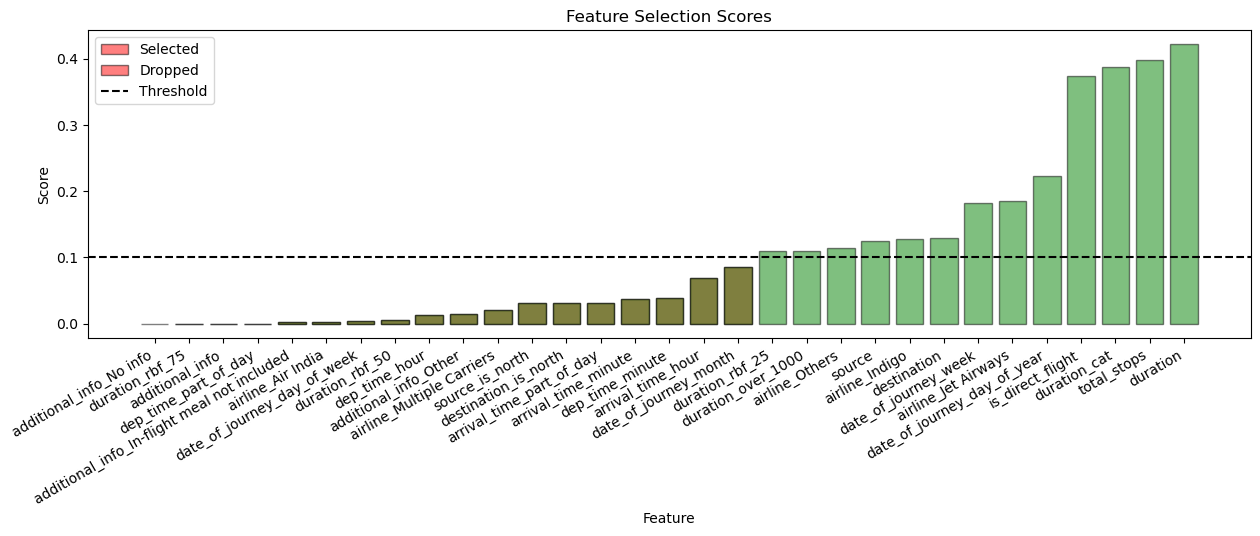

In [71]:
import matplotlib.pyplot as plt
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
    params = dict(
        x=i,
        height=score,
        edgecolor="black",
        alpha=0.5
     )

    if score < THRESHOLD:
        bar = ax.bar(
        color="red",
         **params)
        
    if not dropped_bar:
           dropped_bar = bar[0]
    else:
        bar = ax.bar(
        color="green",
        **params
        )
        
    if not selected_bar:
        selected_bar = bar[0]

thresh_line = ax.axhline(
            y=0.1,
           color="black",
           linestyle="--"
)

ax.set_xticks(
       ticks=range(len(sorted_feat_imp)),
       labels=list(sorted_feat_imp.keys()),
        rotation=30,
        ha="right")

ax.set(
    xlabel="Feature",
    ylabel="Score",
    title="Feature Selection Scores"
)

ax.legend(
    handles=[selected_bar, dropped_bar, thresh_line],
     labels=["Selected", "Dropped", "Threshold"],
     loc="upper left"
)

plt.show()
